<center><font size=5>基于用户行为序列的流失率预测</font></center>

* <font size=4>背景</font>：
<br/>深度学习不仅在NLP和CV领域取得了重要突破，在推荐与广告系统等经典互联网应用中也有很多应用。长期以来用户行为序列分析与预测都是推荐/搜索/广告等领域的重要课题。本文基于前人针对社交网络用户流失的分析方法，分析了音乐APP用户的行为习惯，建立了lightGBM和LSTM预测模型。
  
  
* <font size=4>结论</font>：
* 1.基于用户活跃天数的LSTM模型能有效预测用户的流失情况，效果(F1得分0.98)略低于经典的模型lightGBM(F1得分0.99)。
* 2.词向量与tsne结合的方式，能够有效的提取歌曲风格和用户关注话题信息。
* 3.用户流失(留存)最关键的因素是：最后1次使用日期，使用天数，平均每(活跃)天收听的歌曲数，是否vip客户，平均每(活跃)天操作次数，用具体的操作类型、操作页面、用户基础属性等因素关系不大。
  
  
* <font size=4>方法</font>:
* 1.用户行为序编码。
* 2.基于bert-embedding+tsne的词向量编码。
* 3.Kmeans聚类。
* 4.lightGBM分类与SHAP解释。
* 5.LSTM序列预测。
  
  
* <font size=4>主要参考文献</font>：
<br/>[I Know You’ll Be Back: Interpretable New User Clustering and Churn Prediction on a Mobile Social Application](https://arxiv.org/abs/1910.01447)
<br/>由于作者没有提供数据集，只能根据作者提供的[源码](https://github.com/yangji9181/ClusChurn)，使用[2021DIGIX赛题数据集](https://developer.huawei.com/consumer/cn/activity/devStarAI/algo/competition.html#/preliminary/info/004/data)近似复现。
比赛数据（采样+脱敏后）抽取的时间范围是连续60 天的用户行为数据和行为对应匹配的用户、歌曲、歌手数据。
  
  
* <font size=4>其他参考文献</font>：
* 基于lstm和cnn的方法:[ChurnPrediction](https://github.com/SingingData/ChurnPrediction),[《自然语言处理：基于预训练模型的方法》4.6.7基于循环神经网络的情感分类](https://github.com/HIT-SCIR/plm-nlp-code/blob/main/chp4/lstm_sent_polarity.py)
* 基于lightGBM的方法:[客户流失预测及营销方案](https://mp.weixin.qq.com/s/nq_ZX6u8o5S_phrJ3AFOvg)，[源码](https://github.com/aialgorithm/Blog/tree/master/projects/%E5%AE%A2%E6%88%B7%E6%B5%81%E5%A4%B1%E9%A2%84%E6%B5%8B%E5%8F%8A%E8%90%A5%E9%94%80),[可解释机器学习-shap value的使用](https://blog.csdn.net/qq_41103204/article/details/104896630)
* [推荐中的序列化建模：Session-based neural recommendation](https://zhuanlan.zhihu.com/p/30720579)
* [DeepCTR：易用可扩展的深度学习点击率预测算法包](https://zhuanlan.zhihu.com/p/53231955)
  
  
* <font size=4>思考</font>：
* 1.数据格式的整理占用了80%的时间，实际工作接触的数据往往会比竞赛数据有更多的异常。
* 2.由于作者未能提供原始数据，很多情况下只能猜测源码的思路，比较吃力，说明一个好的分享应该尽可能完整，方便复现。
* 3.深度学习的难度一方面在于模型本身(包括数学原理)的复杂，另一方面在于NLP/CV之外的案例很少，需要大量查阅+尝试才能形成匹配的思路。
* 4.硬件资源(特别是GPU)限制了很多从建模到调参的很多想法。
* 5.现实中大量的不均衡类别场景，如果能根据业务设计优化目标(损失函数)，也许会比经典的F1、混淆矩阵评估更有价值。

# 一.数据预处理：  
使用2021DIGIX赛题数据集：2021_1_data.zip.[基于多目标多视图的用户留存周期预测](https://developer.huawei.com/consumer/cn/activity/devStarAI/algo/competition.html#/preliminary/info/004/data),
<br/>也可在[百度飞桨AI studio](https://aistudio.baidu.com/aistudio/datasetdetail/105868/0)下载

In [5]:
#csv文件拆分并转换成parquet
#https://www.cnblogs.com/harrylyx/p/15141986.html
#https://www.cnblogs.com/hider/p/15263528.html

In [6]:
import pandas as pd
import numpy as np

## 1.1.用户特征表user_info分层抽样，作为后续数据表筛选的基准

In [28]:
#用户特征表
user_info_df = pd.read_csv('2_user_info.csv', sep='|')
user_info_df.head()

,device_id,gender,age,device,city,is_vip,topics
0,203724992,0.0,1.0,34,167,NaN,NaN
1,203709051,0.0,1.0,268,289,1.0,NaN
2,203685345,0.0,NaN,178,59,NaN,NaN
3,203650429,0.0,4.0,167,270,0.0,NaN
4,203636013,0.0,1.0,517,91,NaN,NaN


In [29]:
#用户数量统计:原始文件共200万用户
print(len(user_info_df))
print(len(user_info_df['device_id'].unique()))

2000000
2000000


In [30]:
#观察数据分布:由于内存限制需要分层抽样，所以从gender和is_vip两个变量入手
user_info_df[['gender','is_vip']].value_counts(dropna=False)

gender  is_vip
0.0     NaN       1187720
1.0     NaN        561165
0.0     0.0         98499
        1.0         74591
1.0     0.0         45719
        1.0         28032
NaN     NaN          4069
        0.0           117
        1.0            88
dtype: int64

In [31]:
#替换异常值
user_info_df['gender'].fillna(-99, inplace = True)
user_info_df['is_vip'].fillna(-99, inplace = True)
user_info_df[['gender','is_vip']].value_counts(dropna=False)

gender  is_vip
 0.0    -99.0     1187720
 1.0    -99.0      561165
 0.0     0.0        98499
         1.0        74591
 1.0     0.0        45719
         1.0        28032
-99.0   -99.0        4069
         0.0          117
         1.0           88
dtype: int64

In [11]:
#由于内存限制，分层抽样20万用户进行分析
from sklearn.model_selection import train_test_split
user_info_df,X_test, y_train, y_test = train_test_split(user_info_df,user_info_df[['gender','is_vip']],
                                                    test_size=0.9, stratify=user_info_df[['gender','is_vip']],random_state=10)
print(len(user_info_df))
print(user_info_df.head())

200000
         device_id  gender  age  device  city  is_vip topics
1062515   30341045     0.0  2.0     167   321     0.0    NaN
544103   175882254     0.0  2.0     295    19     1.0    NaN
1989442  112512666     1.0  3.0     285   102   -99.0    NaN
1917752   20486702     0.0  NaN      28   273   -99.0    NaN
1991476    6981221     0.0  3.0     311   122   -99.0    NaN


In [12]:
#清空不用的变量
del X_test, y_train, y_test

## 1.2.读取其他数据文件

In [95]:
#设备活跃表device_active读取
device_active_df = pd.read_csv('1_device_active.csv', sep='|')
print(len(device_active_df))
print(device_active_df.head())

2000000
   device_id                                               days
0  194045574                 4#15#22#34#35#36#38#40#41#42#43#44
1  194045591  1#4#8#10#11#12#13#14#15#16#17#18#19#20#21#22#2...
2  194045955  1#2#3#4#5#6#7#9#10#11#12#13#16#20#21#22#23#24#...
3  194046101            1#2#15#46#49#50#51#52#53#54#55#56#57#59
4  194046455  4#6#9#10#11#12#13#14#15#19#20#22#23#24#25#26#2...


In [96]:
#设备活跃表device_active筛选
device_active_df=device_active_df[device_active_df['device_id'].isin(user_info_df['device_id'])]
print(len(device_active_df))
print(device_active_df.head())

200000
    device_id                                               days
0   194045574                 4#15#22#34#35#36#38#40#41#42#43#44
15  194048640  1#6#10#11#12#14#15#18#20#21#22#23#27#28#29#34#...
23  194050284                 1#3#4#6#38#39#41#42#50#53#54#55#57
32  194052024             10#19#23#33#38#41#42#43#44#45#46#51#60
37  194053501  1#3#4#5#6#7#8#12#13#15#16#17#19#21#23#25#27#29...


In [15]:
#用户行为表user_behavior筛选：由于文件接近10G，采用分块读取


reader = pd.read_csv('4_user_behavior.csv', sep='|', chunksize=2000000)
for i, chunk in enumerate(reader):
    print(i, '  ', len(chunk))
    #选择数据
    temp_df=chunk[chunk['device_id'].isin(user_info_df['device_id'])]
    if i==0 and len(temp_df)>0:
        user_behavior_df=temp_df
    if i>0 and len(temp_df)>0:
        user_behavior_df=pd.concat([user_behavior_df,temp_df],ignore_index=True)


0    2000000
1    2000000
2    2000000
3    2000000
4    2000000
5    2000000
6    2000000
7    2000000
8    2000000
9    2000000
10    2000000
11    2000000
12    2000000
13    2000000
14    2000000
15    2000000
16    1049707


In [16]:
#查看用户行为数据:有19.5万个设备有记录，超出预期
print(len(user_behavior_df))
print(len(user_behavior_df['device_id'].unique()))
print(user_behavior_df.head())

3307124
195008
   device_id  day                                              pages  \
0  203726210    8                                     null#null#null   
1  203718406   46  null#32#32#16#32#32#32#null#32#16#16#16#16#32#...   
2  203695489   36                                              16#16   
3  203663610   26  29#16#29#29#29#29#null#29#29#29#29#29#29#29#29...   
4  203649792   36                                                 16   

                                           music_ids  \
0                                     null#null#null   
1  5017116#4973316#4602314#4602314#4602314#460231...   
2                                    4632924#4632924   
3  10203279#8598481#4563053#4184994#4872587#10128...   
4                                            9048154   

                                             actions  channel  
0                                              1#1#1      8.0  
1          3#1#1#1#1#1#1#7#1#2#2#4#4#1#1#8#1#1#1#8#1      5.0  
2                      

In [17]:
#删除多余变量
del chunk,temp_df

In [18]:
#读取歌曲信息表music_info：由于pandas读取有错误，忽略错误行
music_info_df = pd.read_csv('3_music_info.csv', sep='|',error_bad_lines=False,engine='python')
print(len(music_info_df))
music_info_df.head()

/Applications/anaconda3/envs/mypy37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 21039: '|' expected after '"'
Skipping line 21466: '|' expected after '"'
Skipping line 23006: '|' expected after '"'
Skipping line 23830: '|' expected after '"'
Skipping line 32110: '|' expected after '"'
Skipping line 36033: '|' expected after '"'
Skipping line 36034: '|' expected after '"'
Skipping line 38482: '|' expected after '"'
Skipping line 60321: '|' expected after '"'
Skipping line 113108: '|' expected after '"'
Skipping line 118738: '|' expected after '"'
Skipping line 127295: '|' expected after '"'
Skipping line 128527: '|' expected after '"'
Skipping line 144796: '|' expected after '"'
Skipping line 145969: '|' expected after '"'
Skipping line 145997: '|' expected after '"'
Skipping line 145998: '|' e

Skipping line 1735694: field larger than field limit (131072)
Skipping line 1739682: '|' expected after '"'
Skipping line 1762421: '|' expected after '"'
Skipping line 1762816: '|' expected after '"'
Skipping line 1764423: '|' expected after '"'
Skipping line 1766600: '|' expected after '"'
Skipping line 1772618: '|' expected after '"'
Skipping line 1772761: '|' expected after '"'
Skipping line 1794883: '|' expected after '"'
Skipping line 1795646: '|' expected after '"'
Skipping line 1804120: '|' expected after '"'
Skipping line 1811722: '|' expected after '"'
Skipping line 1811925: '|' expected after '"'
Skipping line 1842542: '|' expected after '"'
Skipping line 1845548: '|' expected after '"'
Skipping line 1870660: '|' expected after '"'
Skipping line 1876094: '|' expected after '"'
Skipping line 1887701: '|' expected after '"'
Skipping line 1891456: '|' expected after '"'
Skipping line 1895580: '|' expected after '"'
Skipping line 1896799: '|' expected after '"'
Skipping line 1897

3373077


,music_id,title,artist_id,album,is_paid,comment,comment_cnt
0,10444549.0,Somewhere Before,NaN,As Long As You're Living Yours: The Music of K...,1.0,NaN,0
1,10444405.0,Simple Gifts,NaN,Sleep Baby,1.0,NaN,0
2,10444351.0,"Only Pretty, What A Pity",277775.0,Everything Playing,1.0,NaN,0
3,10444288.0,The Bergen,303217.0,Threads Of Time,1.0,NaN,0
4,10444246.0,I Shot The Sheriff,NaN,"The Complete Show, Oakland Auditorium, Ca. Nov...",1.0,NaN,0


In [19]:
#读取歌手信息表artist_info
artist_info_df = pd.read_csv('5_artist_info.csv', sep='|')
print(len(artist_info_df))
artist_info_df.head()

303423


,artist_id,artist,style
0,1,Sam Feldt、Halsey,NaN
1,2,王凯,NaN
2,3,The Mary Onette,摇滚
3,4,OXANA,NaN
4,5,Comiccon,NaN


In [20]:
#垃圾回收，减少内存占用
#https://www.cnblogs.com/vamei/p/3232088.html
import gc
gc.collect()

66

## 1.3.用户行为序列处理

In [21]:
#重置索引避免重复
device_active_df = device_active_df.reset_index(drop = True)

#包tqdm是用来对可迭代对象执行时生成一个进度条用以监视程序运行过程
from tqdm import tqdm
#设备活跃表device_active日期处理
tqdm.pandas(desc='device')
device_active_df['days_list'] = device_active_df['days'].progress_apply(lambda x:[int(y) for y in x.split("#")])
device_active_df.head()

device: 100%|██████████| 200000/200000 [00:02<00:00, 75731.58it/s]


,device_id,days,days_list
0,194045574,4#15#22#34#35#36#38#40#41#42#43#44,"[4, 15, 22, 34, 35, 36, 38, 40, 41, 42, 43, 44]"
1,194048640,1#6#10#11#12#14#15#18#20#21#22#23#27#28#29#34#...,"[1, 6, 10, 11, 12, 14, 15, 18, 20, 21, 22, 23,..."
2,194050284,1#3#4#6#38#39#41#42#50#53#54#55#57,"[1, 3, 4, 6, 38, 39, 41, 42, 50, 53, 54, 55, 57]"
3,194052024,10#19#23#33#38#41#42#43#44#45#46#51#60,"[10, 19, 23, 33, 38, 41, 42, 43, 44, 45, 46, 5..."
4,194053501,1#3#4#5#6#7#8#12#13#15#16#17#19#21#23#25#27#29...,"[1, 3, 4, 5, 6, 7, 8, 12, 13, 15, 16, 17, 19, ..."


In [22]:
#提取设备日期标签：活跃天数,最后活跃日期
device_active_df['days_len']=device_active_df['days_list'].map(len)
device_active_df['days_max']=device_active_df['days_list'].map(max)
device_active_df.head()

,device_id,days,days_list,days_len,days_max
0,194045574,4#15#22#34#35#36#38#40#41#42#43#44,"[4, 15, 22, 34, 35, 36, 38, 40, 41, 42, 43, 44]",12,44
1,194048640,1#6#10#11#12#14#15#18#20#21#22#23#27#28#29#34#...,"[1, 6, 10, 11, 12, 14, 15, 18, 20, 21, 22, 23,...",25,60
2,194050284,1#3#4#6#38#39#41#42#50#53#54#55#57,"[1, 3, 4, 6, 38, 39, 41, 42, 50, 53, 54, 55, 57]",13,57
3,194052024,10#19#23#33#38#41#42#43#44#45#46#51#60,"[10, 19, 23, 33, 38, 41, 42, 43, 44, 45, 46, 5...",13,60
4,194053501,1#3#4#5#6#7#8#12#13#15#16#17#19#21#23#25#27#29...,"[1, 3, 4, 5, 6, 7, 8, 12, 13, 15, 16, 17, 19, ...",37,60


In [23]:
#用户行为数据序列化:注意na和null替换
user_behavior_df.fillna(value='0',inplace=True)
tqdm.pandas(desc='user_behavior')
user_behavior_df['pages_list'] = user_behavior_df['pages'].progress_apply(lambda x:[int(y) for y in x.replace('null','0').split("#")])
user_behavior_df['music_ids_list'] = user_behavior_df['music_ids'].progress_apply(lambda x:[int(y) for y in x.replace('null','0').split("#")])
user_behavior_df['actions_list'] = user_behavior_df['actions'].progress_apply(lambda x:[int(y) for y in x.replace('null','0').split("#")])


user_behavior: 100%|██████████| 3307124/3307124 [01:38<00:00, 33714.63it/s]


In [24]:
user_behavior_df.head()

,device_id,day,pages,music_ids,actions,channel,pages_list,music_ids_list,actions_list
0,203726210,8,null#null#null,null#null#null,1#1#1,8.0,"[0, 0, 0]","[0, 0, 0]","[1, 1, 1]"
1,203718406,46,null#32#32#16#32#32#32#null#32#16#16#16#16#32#...,5017116#4973316#4602314#4602314#4602314#460231...,3#1#1#1#1#1#1#7#1#2#2#4#4#1#1#8#1#1#1#8#1,5.0,"[0, 32, 32, 16, 32, 32, 32, 0, 32, 16, 16, 16,...","[5017116, 4973316, 4602314, 4602314, 4602314, ...","[3, 1, 1, 1, 1, 1, 1, 7, 1, 2, 2, 4, 4, 1, 1, ..."
2,203695489,36,16#16,4632924#4632924,1#1,5.0,"[16, 16]","[4632924, 4632924]","[1, 1]"
3,203663610,26,29#16#29#29#29#29#null#29#29#29#29#29#29#29#29...,10203279#8598481#4563053#4184994#4872587#10128...,1#1#1#1#1#1#7#1#1#1#1#1#1#1#1#1#1#1#8#1#1#1#1#...,5.0,"[29, 16, 29, 29, 29, 29, 0, 29, 29, 29, 29, 29...","[10203279, 8598481, 4563053, 4184994, 4872587,...","[1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,203649792,36,16,9048154,1,5.0,[16],[9048154],[1]


In [25]:
#提取特征
user_behavior_df['pages_len']=user_behavior_df['pages_list'].map(len)
user_behavior_df['pages_max']=user_behavior_df['pages_list'].map(max)
user_behavior_df['pages_unique']=user_behavior_df['pages_list'].map(lambda x:len(set(x)))
user_behavior_df['music_ids_len']=user_behavior_df['music_ids_list'].map(len)
user_behavior_df['music_ids_max']=user_behavior_df['music_ids_list'].map(max)
user_behavior_df['music_ids_unique']=user_behavior_df['music_ids_list'].map(lambda x:len(set(x)))
user_behavior_df['actions_len']=user_behavior_df['actions_list'].map(len)
user_behavior_df['actions_max']=user_behavior_df['actions_list'].map(max)
user_behavior_df['actions_unique']=user_behavior_df['actions_list'].map(lambda x:len(set(x)))
user_behavior_df.head()

,device_id,day,pages,music_ids,actions,channel,pages_list,music_ids_list,actions_list,pages_len,pages_max,pages_unique,music_ids_len,music_ids_max,music_ids_unique,actions_len,actions_max,actions_unique
0,203726210,8,null#null#null,null#null#null,1#1#1,8.0,"[0, 0, 0]","[0, 0, 0]","[1, 1, 1]",3,0,1,3,0,1,3,1,1
1,203718406,46,null#32#32#16#32#32#32#null#32#16#16#16#16#32#...,5017116#4973316#4602314#4602314#4602314#460231...,3#1#1#1#1#1#1#7#1#2#2#4#4#1#1#8#1#1#1#8#1,5.0,"[0, 32, 32, 16, 32, 32, 32, 0, 32, 16, 16, 16,...","[5017116, 4973316, 4602314, 4602314, 4602314, ...","[3, 1, 1, 1, 1, 1, 1, 7, 1, 2, 2, 4, 4, 1, 1, ...",21,32,3,21,10235775,9,21,8,6
2,203695489,36,16#16,4632924#4632924,1#1,5.0,"[16, 16]","[4632924, 4632924]","[1, 1]",2,16,1,2,4632924,1,2,1,1
3,203663610,26,29#16#29#29#29#29#null#29#29#29#29#29#29#29#29...,10203279#8598481#4563053#4184994#4872587#10128...,1#1#1#1#1#1#7#1#1#1#1#1#1#1#1#1#1#1#8#1#1#1#1#...,5.0,"[29, 16, 29, 29, 29, 29, 0, 29, 29, 29, 29, 29...","[10203279, 8598481, 4563053, 4184994, 4872587,...","[1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, ...",26,29,3,26,10203279,25,26,8,3
4,203649792,36,16,9048154,1,5.0,[16],[9048154],[1],1,16,1,1,9048154,1,1,1,1


In [26]:
#选取30日之前的信息
temp_df=df =user_behavior_df.loc[user_behavior_df['day']<=30,['device_id', 'day','channel',
       'pages_list', 'music_ids_list', 'actions_list']].sort_values(by=['device_id', 'day'],
                                                                                     ascending=[True,True]) 
temp_df=temp_df.reset_index(drop = True)
temp_df.head()

,device_id,day,channel,pages_list,music_ids_list,actions_list
0,2452,4,5.0,"[16, 16, 16, 16, 16, 16, 18, 16, 16, 16, 16, 1...","[9266462, 10274802, 5284244, 7887489, 6904175,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,7181,1,5.0,"[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1977322, 1977322, 1977322, 1977322, 1977322, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2,7181,16,5.0,[32],[9111072],[1]
3,8685,2,5.0,"[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1415848, 1415848, 1415848, 1415848, 1415848, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,8685,3,5.0,"[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1415848, 1415848, 1415848, 1415848, 1415848, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [27]:
#指标序列化
user_behavior_seq_df=temp_df.groupby(['device_id'],as_index=False).agg(lambda x: list(x))
user_behavior_seq_df.head()

,device_id,day,channel,pages_list,music_ids_list,actions_list
0,2452,[4],[5.0],"[[16, 16, 16, 16, 16, 16, 18, 16, 16, 16, 16, ...","[[9266462, 10274802, 5284244, 7887489, 6904175...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,7181,"[1, 16]","[5.0, 5.0]","[[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, ...","[[1977322, 1977322, 1977322, 1977322, 1977322,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1]]"
2,8685,"[2, 3, 5, 6, 8, 9, 11, 12, 13, 14, 19, 22, 23,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, ...","[[1415848, 1415848, 1415848, 1415848, 1415848,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, ..."
3,9219,"[1, 2, 7, 9, 10, 20, 24, 25, 26, 30]","[2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 2.0, ...","[[28], [28, 28], [28, 28, 28, 28], [28, 28, 28...","[[9651688], [9651688, 9651688], [1995380, 9651...","[[1], [1, 1], [1, 1, 1, 1], [1, 1, 1], [1, 1],..."
4,9529,"[1, 8, 23, 25, 26, 27, 29]","[0, 0, 0, 0, 0, 0, 0]","[[16], [16], [16, 16], [16, 16], [16, 16], [16...","[[1136194], [1136194], [1136194, 1136194], [11...","[[1], [1], [1, 1], [1, 1], [1, 1], [1], [1, 1]]"


In [28]:
#处理序列嵌套
from itertools import chain
user_behavior_seq_df['pages_seq']=user_behavior_seq_df['pages_list'].map(lambda x:list(chain(*x)))
user_behavior_seq_df['music_ids_seq']=user_behavior_seq_df['music_ids_list'].map(lambda x:list(chain(*x)))
user_behavior_seq_df['actions_seq']=user_behavior_seq_df['actions_list'].map(lambda x:list(chain(*x)))
user_behavior_seq_df.drop(['pages_list','music_ids_list','actions_list'],axis=1, inplace=True)
user_behavior_seq_df.head()

,device_id,day,channel,pages_seq,music_ids_seq,actions_seq
0,2452,[4],[5.0],"[16, 16, 16, 16, 16, 16, 18, 16, 16, 16, 16, 1...","[9266462, 10274802, 5284244, 7887489, 6904175,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,7181,"[1, 16]","[5.0, 5.0]","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1977322, 1977322, 1977322, 1977322, 1977322, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2,8685,"[2, 3, 5, 6, 8, 9, 11, 12, 13, 14, 19, 22, 23,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1415848, 1415848, 1415848, 1415848, 1415848, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,9219,"[1, 2, 7, 9, 10, 20, 24, 25, 26, 30]","[2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 2.0, ...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[9651688, 9651688, 9651688, 1995380, 9651688, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,9529,"[1, 8, 23, 25, 26, 27, 29]","[0, 0, 0, 0, 0, 0, 0]","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]","[1136194, 1136194, 1136194, 1136194, 1136194, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [29]:
#特征提取
from collections import Counter
user_behavior_seq_df['channel_most']=user_behavior_seq_df['channel'].map(lambda x:Counter(x).most_common(1)[0][0])
user_behavior_seq_df['channel_len']=user_behavior_seq_df['channel'].map(len)
user_behavior_seq_df['channel_unique']=user_behavior_seq_df['channel'].map(lambda x:len(set(x)))
user_behavior_seq_df['pages_most']=user_behavior_seq_df['pages_seq'].map(lambda x:Counter(x).most_common(1)[0][0])
user_behavior_seq_df['pages_len']=user_behavior_seq_df['pages_seq'].map(lambda x:len(x))
user_behavior_seq_df['pages_unique']=user_behavior_seq_df['pages_seq'].map(lambda x:len(set(x)))
user_behavior_seq_df['music_ids_most']=user_behavior_seq_df['music_ids_seq'].map(lambda x:Counter(x).most_common(1)[0][0])
user_behavior_seq_df['music_ids_unique']=user_behavior_seq_df['music_ids_seq'].map(lambda x:len(set(x)))
user_behavior_seq_df['actions_most']=user_behavior_seq_df['actions_seq'].map(lambda x:Counter(x).most_common(1)[0][0])
user_behavior_seq_df['actions_unique']=user_behavior_seq_df['actions_seq'].map(lambda x:len(set(x)))
user_behavior_seq_df.head()

,device_id,day,channel,pages_seq,music_ids_seq,actions_seq,channel_most,channel_len,channel_unique,pages_most,pages_len,pages_unique,music_ids_most,music_ids_unique,actions_most,actions_unique
0,2452,[4],[5.0],"[16, 16, 16, 16, 16, 16, 18, 16, 16, 16, 16, 1...","[9266462, 10274802, 5284244, 7887489, 6904175,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.0,1,1,16,25,4,0,23,1,3
1,7181,"[1, 16]","[5.0, 5.0]","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1977322, 1977322, 1977322, 1977322, 1977322, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",5.0,2,1,32,15,1,1977322,7,1,1
2,8685,"[2, 3, 5, 6, 8, 9, 11, 12, 13, 14, 19, 22, 23,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1415848, 1415848, 1415848, 1415848, 1415848, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.0,15,2,32,280,3,1415848,13,1,3
3,9219,"[1, 2, 7, 9, 10, 20, 24, 25, 26, 30]","[2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 2.0, ...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[9651688, 9651688, 9651688, 1995380, 9651688, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.0,10,2,28,21,1,9651688,6,1,1
4,9529,"[1, 8, 23, 25, 26, 27, 29]","[0, 0, 0, 0, 0, 0, 0]","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]","[1136194, 1136194, 1136194, 1136194, 1136194, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,7,1,16,11,1,1136194,1,1,1


In [30]:
#释放内存
del temp_df
gc.collect()

20

## 1.4.拼接用户音乐与对应歌手的信息

In [31]:
#拼接音乐信息表
temp_df=pd.merge(music_info_df,artist_info_df,how='left', on='artist_id')
print(len(temp_df))
temp_df.head()

3373077


,music_id,title,artist_id,album,is_paid,comment,comment_cnt,artist,style
0,10444549.0,Somewhere Before,NaN,As Long As You're Living Yours: The Music of K...,1.0,NaN,0,NaN,NaN
1,10444405.0,Simple Gifts,NaN,Sleep Baby,1.0,NaN,0,NaN,NaN
2,10444351.0,"Only Pretty, What A Pity",277775.0,Everything Playing,1.0,NaN,0,The Lovin' Spoonfu,摇滚
3,10444288.0,The Bergen,303217.0,Threads Of Time,1.0,NaN,0,Cherish The Ladie,世界音乐
4,10444246.0,I Shot The Sheriff,NaN,"The Complete Show, Oakland Auditorium, Ca. Nov...",1.0,NaN,0,NaN,NaN


In [32]:
#音乐歌手、付费类型、评论数、风格字典
music_dict=temp_df[['music_id','artist_id','is_paid','comment_cnt','style']].set_index('music_id').T.to_dict('list')
print([i for i in music_dict][:3])
print([i for i in music_dict.values()][:3])

/Applications/anaconda3/envs/mypy37/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  


[10444549.0, 10444405.0, 10444351.0]
[[nan, 1.0, 0, nan], [nan, 1.0, 0, nan], [277775.0, 1.0, 0, '摇滚']]


In [36]:
#释放内存
del temp_df
gc.collect()

56

In [38]:
#匹配信息
user_behavior_seq_df['artist_id']=user_behavior_seq_df['music_ids_seq']
user_behavior_seq_df['is_paid']=user_behavior_seq_df['music_ids_seq']
user_behavior_seq_df['comment_cnt']=user_behavior_seq_df['music_ids_seq']
user_behavior_seq_df['style']=user_behavior_seq_df['music_ids_seq']
#处理
from tqdm import tqdm,trange
import time
for i in trange(len(user_behavior_seq_df)):
    x=user_behavior_seq_df.at[i,'music_ids_seq']
    #注意去除异常值
    x = list(filter(lambda x: x>0, x))
    y=list(map(lambda x:music_dict.get(x,[np.nan,np.nan,np.nan,np.nan]),x))
    user_behavior_seq_df.at[i,'artist_id']=list(filter(lambda x: pd.isnull(x)==False,[x[0] for x in y]))
    user_behavior_seq_df.at[i,'is_paid']=list(filter(lambda x: pd.isnull(x)==False,[x[1] for x in y]))
    user_behavior_seq_df.at[i,'comment_cnt']=list(filter(lambda x: pd.isnull(x)==False,[x[2] for x in y]))
    user_behavior_seq_df.at[i,'style']=list(filter(lambda x: pd.isnull(x)==False,[x[3] for x in y]))
user_behavior_seq_df.head()

100%|██████████| 182592/182592 [03:28<00:00, 875.39it/s] 


,device_id,day,channel,pages_seq,music_ids_seq,actions_seq,channel_most,channel_len,channel_unique,pages_most,pages_len,pages_unique,music_ids_most,music_ids_unique,actions_most,actions_unique,artist_id,is_paid,comment_cnt,style
0,2452,[4],[5.0],"[16, 16, 16, 16, 16, 16, 18, 16, 16, 16, 16, 1...","[9266462, 10274802, 5284244, 7887489, 6904175,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.0,1,1,16,25,4,0,23,1,3,"[293401.0, 230558.0, 233249.0, 223424.0, 28341...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[105, 40, 134, 10, 16, 25, 53, 1379, 48, 13, 0...","[流行, 流行, 流行, 流行, 流行, 流行, 拉丁#流行, 流行, 流行, 流行, 摇滚..."
1,7181,"[1, 16]","[5.0, 5.0]","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1977322, 1977322, 1977322, 1977322, 1977322, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",5.0,2,1,32,15,1,1977322,7,1,1,"[24175.0, 24175.0, 24175.0, 24175.0, 24175.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[33937, 33937, 33937, 33937, 33937, 33937, 339...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行]"
2,8685,"[2, 3, 5, 6, 8, 9, 11, 12, 13, 14, 19, 22, 23,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1415848, 1415848, 1415848, 1415848, 1415848, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.0,15,2,32,280,3,1415848,13,1,3,"[73436.0, 73436.0, 73436.0, 73436.0, 73436.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[169, 169, 169, 169, 169, 169, 169, 169, 169, ...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流..."
3,9219,"[1, 2, 7, 9, 10, 20, 24, 25, 26, 30]","[2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 2.0, ...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[9651688, 9651688, 9651688, 1995380, 9651688, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.0,10,2,28,21,1,9651688,6,1,1,"[205922.0, 205922.0, 205922.0, 205922.0, 20592...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[7, 7, 7, 23, 7, 11, 3, 13, 11, 7, 11, 11, 13,...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流..."
4,9529,"[1, 8, 23, 25, 26, 27, 29]","[0, 0, 0, 0, 0, 0, 0]","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]","[1136194, 1136194, 1136194, 1136194, 1136194, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,7,1,16,11,1,1136194,1,1,1,[],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1076, 1076, 1076, 1076, 1076, 1076, 1076, 107...",[]


In [40]:
#提取特征
#歌手
user_behavior_seq_df['artist_id_unique']=user_behavior_seq_df['artist_id'].map(lambda x:len(set(x)))
#付费
user_behavior_seq_df['is_paid_sum']=user_behavior_seq_df['is_paid'].map(lambda x:sum(x))
#评论
user_behavior_seq_df['comment_cnt_sum']=user_behavior_seq_df['comment_cnt'].map(lambda x:sum(x))
user_behavior_seq_df.head()

,device_id,day,channel,pages_seq,music_ids_seq,actions_seq,channel_most,channel_len,channel_unique,pages_most,...,music_ids_unique,actions_most,actions_unique,artist_id,is_paid,comment_cnt,style,artist_id_unique,is_paid_sum,comment_cnt_sum
0,2452,[4],[5.0],"[16, 16, 16, 16, 16, 16, 18, 16, 16, 16, 16, 1...","[9266462, 10274802, 5284244, 7887489, 6904175,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.0,1,1,16,...,23,1,3,"[293401.0, 230558.0, 233249.0, 223424.0, 28341...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[105, 40, 134, 10, 16, 25, 53, 1379, 48, 13, 0...","[流行, 流行, 流行, 流行, 流行, 流行, 拉丁#流行, 流行, 流行, 流行, 摇滚...",17,21.0,2090
1,7181,"[1, 16]","[5.0, 5.0]","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1977322, 1977322, 1977322, 1977322, 1977322, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",5.0,2,1,32,...,7,1,1,"[24175.0, 24175.0, 24175.0, 24175.0, 24175.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[33937, 33937, 33937, 33937, 33937, 33937, 339...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行]",7,13.0,306775
2,8685,"[2, 3, 5, 6, 8, 9, 11, 12, 13, 14, 19, 22, 23,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1415848, 1415848, 1415848, 1415848, 1415848, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.0,15,2,32,...,13,1,3,"[73436.0, 73436.0, 73436.0, 73436.0, 73436.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[169, 169, 169, 169, 169, 169, 169, 169, 169, ...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流...",10,57.0,51352
3,9219,"[1, 2, 7, 9, 10, 20, 24, 25, 26, 30]","[2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 2.0, ...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[9651688, 9651688, 9651688, 1995380, 9651688, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.0,10,2,28,...,6,1,1,"[205922.0, 205922.0, 205922.0, 205922.0, 20592...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[7, 7, 7, 23, 7, 11, 3, 13, 11, 7, 11, 11, 13,...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流...",1,18.0,219
4,9529,"[1, 8, 23, 25, 26, 27, 29]","[0, 0, 0, 0, 0, 0, 0]","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]","[1136194, 1136194, 1136194, 1136194, 1136194, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,7,1,16,...,1,1,1,[],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1076, 1076, 1076, 1076, 1076, 1076, 1076, 107...",[],0,11.0,11836


In [74]:
#风格处理
user_behavior_seq_df['style_most_name']=''
#循环
for i in trange(len(user_behavior_seq_df)):
    x=user_behavior_seq_df.at[i,'style']
    #注意去除异常值
    if len(x)>0:
        #复合风格拆分后取最多的
        y='#'.join(x)
        y=Counter(y.split(sep='#')).most_common(1)[0][0]
        user_behavior_seq_df.at[i,'style_most_name']=y
user_behavior_seq_df.head()

100%|██████████| 182592/182592 [00:25<00:00, 7268.84it/s]


,device_id,day,channel,pages_seq,music_ids_seq,actions_seq,channel_most,channel_len,channel_unique,pages_most,...,actions_unique,artist_id,is_paid,comment_cnt,style,artist_id_unique,is_paid_sum,comment_cnt_sum,style_most,style_most_name
0,2452,[4],[5.0],"[16, 16, 16, 16, 16, 16, 18, 16, 16, 16, 16, 1...","[9266462, 10274802, 5284244, 7887489, 6904175,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.0,1,1,16,...,3,"[293401.0, 230558.0, 233249.0, 223424.0, 28341...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[105, 40, 134, 10, 16, 25, 53, 1379, 48, 13, 0...","[流行, 流行, 流行, 流行, 流行, 流行, 拉丁#流行, 流行, 流行, 流行, 摇滚...",17,21.0,2090,"[-0.63109016, 0.22949956, -0.6075365, -0.19511...",流行
1,7181,"[1, 16]","[5.0, 5.0]","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1977322, 1977322, 1977322, 1977322, 1977322, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",5.0,2,1,32,...,1,"[24175.0, 24175.0, 24175.0, 24175.0, 24175.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[33937, 33937, 33937, 33937, 33937, 33937, 339...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行]",7,13.0,306775,"[-0.7651284, 0.4849676, -0.8909233, -0.2247727...",流行
2,8685,"[2, 3, 5, 6, 8, 9, 11, 12, 13, 14, 19, 22, 23,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1415848, 1415848, 1415848, 1415848, 1415848, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5.0,15,2,32,...,3,"[73436.0, 73436.0, 73436.0, 73436.0, 73436.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[169, 169, 169, 169, 169, 169, 169, 169, 169, ...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流...",10,57.0,51352,"[-0.7625535, 0.41524613, -0.48051965, -0.61671...",流行
3,9219,"[1, 2, 7, 9, 10, 20, 24, 25, 26, 30]","[2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 2.0, ...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[9651688, 9651688, 9651688, 1995380, 9651688, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.0,10,2,28,...,1,"[205922.0, 205922.0, 205922.0, 205922.0, 20592...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[7, 7, 7, 23, 7, 11, 3, 13, 11, 7, 11, 11, 13,...","[流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流...",1,18.0,219,"[-1.1121037, 0.595823, -0.91955787, -0.0097392...",流行
4,9529,"[1, 8, 23, 25, 26, 27, 29]","[0, 0, 0, 0, 0, 0, 0]","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]","[1136194, 1136194, 1136194, 1136194, 1136194, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,7,1,16,...,1,[],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1076, 1076, 1076, 1076, 1076, 1076, 1076, 107...",[],0,11.0,11836,0,


In [45]:
#备份到本地文件
#https://www.cnblogs.com/harrylyx/p/15141986.html
#https://www.cnblogs.com/hider/p/15263528.html
import tables
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.feather as feather
import pickle
with open('./user_behavior_seq_df.pkl', 'wb') as f:
    pickle.dump(user_behavior_seq_df, f)
with open('./user_behavior_df.pkl', 'wb') as f:
    pickle.dump(user_behavior_df, f)

print('备份完成 ')

备份完成 


In [1]:
#读取pickle文件
import pickle
df=open('./user_behavior_seq_df.pkl','rb')#注意此处是rb
#此处使用的是load(目标文件)
user_behavior_seq_df=pickle.load(df)
df.close()

print('读取完成')

读取完成


# 二.用户聚类
* 参考论文中的流程，先对用户聚类有助于提高流失率预测精度。由于无法获取到用户的社交网络数据，转而使用用户行为聚类。
* 基于用户的行聚类：基于操作时长，操作类型，喜欢的歌曲数量与热度(评论数)，喜欢的歌手数量与风格。
* 没有考虑性别，是否vip等信息，因为这些信息可能区分能力过大，导致用户行为的影响过小[4个步骤教你用聚类分析法进行用户分析](https://jishuin.proginn.com/p/763bfbd605e9)
* 先使用tsne方法对歌手风格降维，然后把降维后的前两维向量作为kmeans的输入.[动手实战基于 ML 的中文短文本聚类](https://zhuanlan.zhihu.com/p/112362700)

## 2.1.歌手风格向量化tsne降维

In [2]:
#风格embedding
style_list=list(set(user_behavior_seq_df['style_most_name']))
#print(style_list)
import torch
from fastNLP import Vocabulary
from fastNLP.embeddings import BertEmbedding
import numpy as np
import pandas as pd
#初始化
vocab = Vocabulary()
embed = BertEmbedding(vocab, model_dir_or_name='cn-base', requires_grad=False)
#循环
def fun_embed(x):
    if len(x)>1:
        words = torch.LongTensor([[vocab.to_index(word) for word in x]])
        y=np.array(embed(words).numpy().mean(axis=0)).mean(axis=0)
    else:
        y=0
    return y
style_vec=list(map(fun_embed,style_list))
style_df=pd.DataFrame({'style_most_name':style_list,'vec':style_vec})
style_df.head()

loading vocabulary file /Users/zhuochen/.fastNLP/embedding/bert-base-chinese/vocab.txt
Load pre-trained BERT parameters from file /Users/zhuochen/.fastNLP/embedding/bert-base-chinese/pytorch_model.bin.


,style_most_name,vec
0,流行,"[-1.2793686, 0.8155391, -0.81094, -0.2655769, ..."
1,,0
2,草原风,"[-0.7356028, 0.5530313, -0.7035904, -0.3973162..."
3,说唱,"[-1.0245255, 0.8199401, -0.15269054, -0.413091..."
4,越剧,"[-0.90574515, 0.46694583, -0.50223905, -0.3588..."


In [5]:
#将风格变量转成常见的样本*特征格式
n=768#fastnlp的词向量维度
style_index=list(['x' + str(j) for j in range(n)])
from tqdm import tqdm
tqdm.pandas(desc='my_bar')
temp_df=style_df['vec'].progress_apply(pd.Series,index=style_index)
temp_df.head()

my_bar: 100%|██████████| 32/32 [00:00<00:00, 774.59it/s]


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x758,x759,x760,x761,x762,x763,x764,x765,x766,x767
0,-1.279369,0.815539,-0.810940,-0.265577,0.383471,-0.854947,-0.057001,0.581599,-0.425656,0.010437,...,-0.237096,0.748048,-0.701064,-1.733449,-0.101800,-0.864982,0.070957,-0.377556,-0.263776,0.172112
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.735603,0.553031,-0.703590,-0.397316,0.260951,-1.099136,0.260379,0.424599,-0.760006,0.585819,...,-0.073147,0.262841,-0.471554,-1.573940,-0.275203,-0.490632,-0.178806,0.228764,0.176955,-0.323884
3,-1.024526,0.819940,-0.152691,-0.413091,0.415911,-1.071084,0.132981,0.454327,-0.975406,-0.179163,...,-0.088169,0.625521,-0.459964,-1.967038,-0.302664,-0.897392,-0.061462,0.172074,-0.169146,-0.099538
4,-0.905745,0.466946,-0.502239,-0.358835,0.486311,-1.320464,0.619967,0.720281,-0.950337,-0.034502,...,-0.078724,0.254649,-0.814785,-1.575930,-0.441682,-1.166417,-0.492276,0.456080,-0.138491,-0.583236


In [12]:
#tsne计算
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,init='pca').fit_transform(np.array(temp_df))
tsne_df = pd.DataFrame({'dim1':X_embedded[:,0],
                        'dim2':X_embedded[:,1],
                        'style_most_name':style_df['style_most_name']},index = style_df.index)
tsne_df.head()

,dim1,dim2,style_most_name
0,-24.092134,-15.032055,流行
1,-70.578026,-34.418716,
2,20.115042,-3.205137,草原风
3,-16.949816,-34.578701,说唱
4,-8.630529,-56.995445,越剧


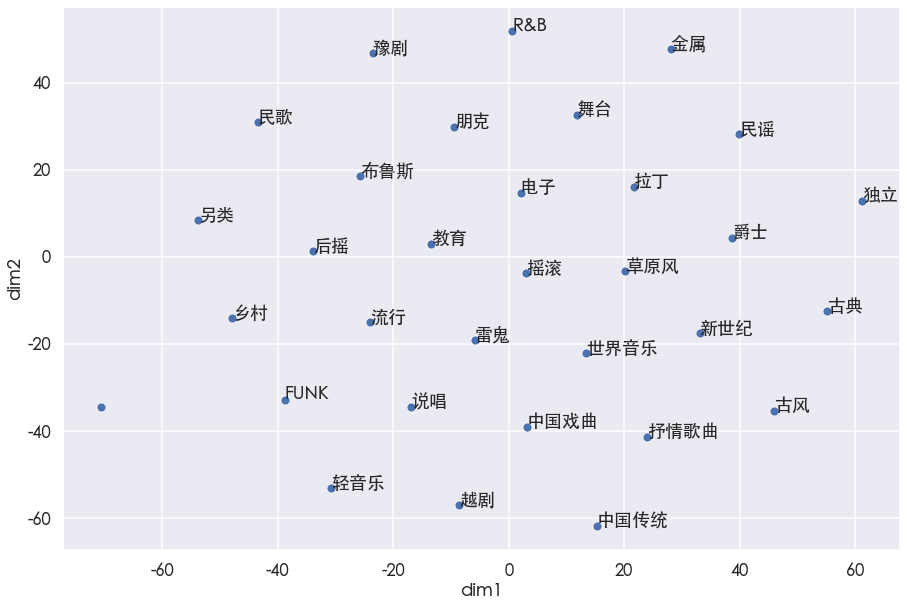

In [13]:
# 可视化展示
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 查看哪些中文字体可用
#font_list=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
#for i in font_list:
    #print(i)
plt.rcParams['font.sans-serif'] = ['Heiti TC']
sns.set(context='talk', font='Heiti TC') 
#作图
plt.figure(figsize=(15, 10))
sns.scatterplot(x="dim1", y="dim2",data=tsne_df)
for i, txt in enumerate(tsne_df['style_most_name']):
    plt.annotate(txt, (tsne_df.dim1[i], tsne_df.dim2[i]))
plt.show()

* 从图中可以看出，很多含义相近的词距离很近，例如中国戏曲/中国传统/越剧。也有少部分离得较远 ，例如中国戏曲和豫剧。
* 整体上bert-embeddin+tsne能相对完整的体现风格的关系

In [14]:
#释放内存
del temp_df
import gc
gc.collect()

10753

## 2.2.Kmeans用户聚类

In [16]:
#构建用户特征数据
#补充日期特征
user_behavior_seq_df['day_max']=user_behavior_seq_df['day'].map(max)
user_behavior_seq_df['day_len']=user_behavior_seq_df['day'].map(len)
user_behavior_seq_df['channel_most']=user_behavior_seq_df['channel_most'].map(int)
#合并
user_f_df=user_behavior_seq_df.loc[:,['device_id','day_max','day_len','channel_most','channel_unique',
                                'actions_unique','pages_unique','pages_len',
                                'music_ids_unique','artist_id_unique',
                                'is_paid_sum','comment_cnt_sum','style_most_name']]
user_f_df=pd.merge(user_f_df,tsne_df,how='left', on='style_most_name',sort=False)
#计算日均值
x_list=list(user_f_df.columns)
x_list.remove('device_id')
x_list.remove('day_max')
x_list.remove('day_len')
x_list.remove('style_most_name')
x_list.remove('dim1')
x_list.remove('dim2')
for x in x_list:
    #print(x)
    user_f_df[x+'_day']=user_f_df[x]/user_f_df['day_len']

#标准化
from sklearn import preprocessing
x_df=pd.DataFrame(preprocessing.scale(user_f_df.drop(['device_id','style_most_name'],axis=1)))
x_list=list(user_f_df.drop(['device_id','style_most_name'],axis=1).columns)
x_df.columns=x_list
x_df.head()

,day_max,day_len,channel_most,channel_unique,actions_unique,pages_unique,pages_len,music_ids_unique,artist_id_unique,is_paid_sum,...,dim2,channel_most_day,channel_unique_day,actions_unique_day,pages_unique_day,pages_len_day,music_ids_unique_day,artist_id_unique_day,is_paid_sum_day,comment_cnt_sum_day
0,-3.660746,-1.174037,-0.104668,-0.775998,0.186513,0.468209,-0.274499,-0.472849,-0.451873,-0.329195,...,0.028378,0.793705,2.570896,4.611555,6.579855,0.193749,1.930478,2.582062,0.246940,-0.599733
1,-1.638309,-1.030480,-0.104668,-0.775998,-1.168403,-1.481938,-0.289385,-0.631862,-0.642033,-0.346504,...,0.028378,0.221017,0.721552,-0.027853,-0.166583,-0.344313,-0.506824,-0.220499,-0.375019,0.218048
2,0.721200,0.835765,-0.104668,0.588331,0.186513,-0.181840,0.105077,-0.572232,-0.584985,-0.251302,...,0.028378,-0.275314,-0.634633,-0.584581,-0.744849,-0.000978,-0.835964,-0.808690,-0.490832,-0.592525
3,0.721200,0.117978,-0.498794,0.588331,-1.168403,-1.481938,-0.280453,-0.641801,-0.756129,-0.335686,...,0.028378,-0.305857,-0.388053,-0.770158,-0.937604,-0.510344,-0.869295,-0.926329,-0.576619,-0.610911
4,0.552664,-0.312694,-0.761544,-0.775998,-1.168403,-1.481938,-0.295339,-0.691493,-0.775145,-0.350832,...,-3.153165,-0.351672,-0.599407,-0.690625,-0.854995,-0.526596,-0.926433,-0.947088,-0.586423,-0.601890


In [17]:
#类别特征：使用onehot处理
onehot_df = pd.get_dummies(user_behavior_seq_df[['channel_most','pages_most','actions_most']],columns=['channel_most','pages_most','actions_most'])
onehot_df.head()

,channel_most_0,channel_most_1,channel_most_2,channel_most_3,channel_most_5,channel_most_6,channel_most_8,channel_most_9,channel_most_11,channel_most_12,...,pages_most_45,pages_most_47,actions_most_1,actions_most_2,actions_most_3,actions_most_4,actions_most_5,actions_most_6,actions_most_7,actions_most_8
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [18]:
#拼接
x_df=pd.concat([user_f_df.loc[:,'device_id'],x_df,onehot_df], axis=1)
x_df.head()

,device_id,day_max,day_len,channel_most,channel_unique,actions_unique,pages_unique,pages_len,music_ids_unique,artist_id_unique,...,pages_most_45,pages_most_47,actions_most_1,actions_most_2,actions_most_3,actions_most_4,actions_most_5,actions_most_6,actions_most_7,actions_most_8
0,2452,-3.660746,-1.174037,-0.104668,-0.775998,0.186513,0.468209,-0.274499,-0.472849,-0.451873,...,0,0,1,0,0,0,0,0,0,0
1,7181,-1.638309,-1.030480,-0.104668,-0.775998,-1.168403,-1.481938,-0.289385,-0.631862,-0.642033,...,0,0,1,0,0,0,0,0,0,0
2,8685,0.721200,0.835765,-0.104668,0.588331,0.186513,-0.181840,0.105077,-0.572232,-0.584985,...,0,0,1,0,0,0,0,0,0,0
3,9219,0.721200,0.117978,-0.498794,0.588331,-1.168403,-1.481938,-0.280453,-0.641801,-0.756129,...,0,0,1,0,0,0,0,0,0,0
4,9529,0.552664,-0.312694,-0.761544,-0.775998,-1.168403,-1.481938,-0.295339,-0.691493,-0.775145,...,0,0,1,0,0,0,0,0,0,0


In [19]:
#kmeans聚类
#使用silhouette选择聚类的数目
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#分别创建分群3-15的KMeans模型
clusters = range(3,16)
sc_scores = []
for k in clusters:  
    kmeans_model = KMeans(n_clusters=k).fit(x_df)
    sc_score = silhouette_score(x_df, kmeans_model.labels_,sample_size=60000, metric='euclidean')
    sc_scores.append(sc_score)
    print("For n_clusters =",k,"The average silhouette_score is :", sc_score)

For n_clusters = 3 The average silhouette_score is : 0.5933289869015085
For n_clusters = 4 The average silhouette_score is : 0.5762863817307868
For n_clusters = 5 The average silhouette_score is : 0.5643884189441813
For n_clusters = 6 The average silhouette_score is : 0.5586307741537836
For n_clusters = 7 The average silhouette_score is : 0.5540408081937437
For n_clusters = 8 The average silhouette_score is : 0.5492803533463748
For n_clusters = 9 The average silhouette_score is : 0.545607936352122
For n_clusters = 10 The average silhouette_score is : 0.5443935193396965
For n_clusters = 11 The average silhouette_score is : 0.5431810255419889
For n_clusters = 12 The average silhouette_score is : 0.5445594163442459
For n_clusters = 13 The average silhouette_score is : 0.5389012210543301
For n_clusters = 14 The average silhouette_score is : 0.5394959825538822
For n_clusters = 15 The average silhouette_score is : 0.5373640992367305


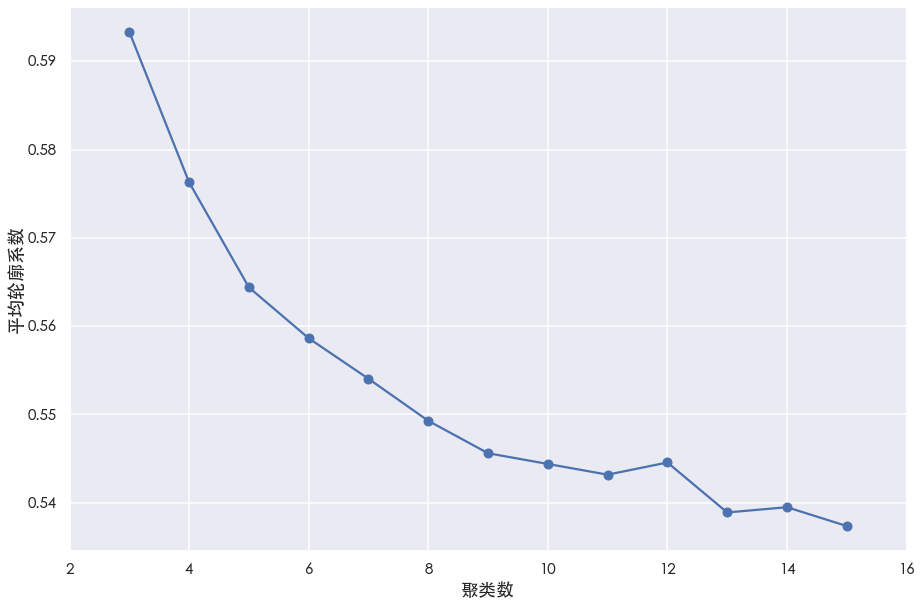

In [24]:
#作出K—平均轮廓系数曲线
plt.figure()
plt.plot(clusters, sc_scores,marker='o')
plt.rcParams['figure.figsize'] = [15,10]
plt.xlabel('聚类数',fontsize=18)#数量
plt.ylabel('平均轮廓系数',fontsize=18)  #样本平均轮廓系数
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(2,16)
plt.show()

* 从轮廓系数图可以发现，随着聚类数目增加，轮廓系数明显下降，说明各个簇样本离中心越来越远。结合已有文献暂定聚6类。
* 由于计算资源有限，未计算所有样本的轮廓系数(silhouette_samples)。

In [25]:
# 正式定义模型
kmeans_model = KMeans(n_clusters=6).fit(x_df)
# 输出类别
y = kmeans_model.predict(x_df)
#拼接
user_f_df['user_type']=y
pd.set_option('display.max_columns', None)
user_f_df.head()

,device_id,day_max,day_len,channel_most,channel_unique,actions_unique,pages_unique,pages_len,music_ids_unique,artist_id_unique,is_paid_sum,comment_cnt_sum,style_most_name,dim1,dim2,channel_most_day,channel_unique_day,actions_unique_day,pages_unique_day,pages_len_day,music_ids_unique_day,artist_id_unique_day,is_paid_sum_day,comment_cnt_sum_day,user_type
0,2452,4,1,5,1,3,4,25,23,17,21.0,2090,流行,-24.092134,-15.032055,5.000000,1.000000,3.000000,4.000000,25.000000,23.000000,17.000000,21.000000,2090.000000,0
1,7181,16,2,5,1,1,1,15,7,7,13.0,306775,流行,-24.092134,-15.032055,2.500000,0.500000,0.500000,0.500000,7.500000,3.500000,3.500000,6.500000,153387.500000,0
2,8685,30,15,5,2,3,3,280,13,10,57.0,51352,流行,-24.092134,-15.032055,0.333333,0.133333,0.200000,0.200000,18.666667,0.866667,0.666667,3.800000,3423.466667,0
3,9219,30,10,2,2,1,1,21,6,1,18.0,219,流行,-24.092134,-15.032055,0.200000,0.200000,0.100000,0.100000,2.100000,0.600000,0.100000,1.800000,21.900000,0
4,9529,29,7,0,1,1,1,11,1,0,11.0,11836,,-70.578026,-34.418716,0.000000,0.142857,0.142857,0.142857,1.571429,0.142857,0.000000,1.571429,1690.857143,0


In [27]:
#分析每类用户的属性
print('各类用户数量')
print(user_f_df[['user_type','device_id']].groupby(["user_type"]).count())
#根据变异系数选择哪些变量更具有区分性
aggregated = pd.DataFrame(user_f_df.drop(['device_id','style_most_name'],axis=1).groupby('user_type', as_index=False).agg(['mean']))
cv_df=pd.DataFrame(aggregated.std()/aggregated.mean())
cv_df.columns=list(['cv'])
#显示所有列，把行显示设置成最大
pd.set_option('display.max_columns', None)
#显示所有行，把列显示设置成最大
pd.set_option('display.max_rows', None)
cv_df=cv_df.sort_values(['cv'], ascending=[False])
cv_df

各类用户数量
           device_id
user_type           
0              30769
1              29497
2              30471
3              29832
4              30541
5              31482


,,cv
artist_id_unique,mean,0.008362
music_ids_unique,mean,0.007224
is_paid_sum_day,mean,0.007098
pages_len,mean,0.007088
is_paid_sum,mean,0.006865
comment_cnt_sum,mean,0.006800
artist_id_unique_day,mean,0.006466
music_ids_unique_day,mean,0.006280
pages_len_day,mean,0.006042
channel_most_day,mean,0.005360


In [28]:
#选择前5个指标
var_list=list(range(5))
for i in range(5):
    var_list[i]=cv_df.index[i][0]
var_list

['artist_id_unique',
 'music_ids_unique',
 'is_paid_sum_day',
 'pages_len',
 'is_paid_sum']

In [29]:
#主要指标的分位数
def fun_q25(x):
    return x.quantile(0.25)
def fun_q75(x):
    return x.quantile(0.75)
q_df = user_f_df.groupby('user_type', as_index=False)[var_list].agg(['mean','median',fun_q25,fun_q75])
q_df

artist_id_unique                        music_ids_unique         \
                      mean median fun_q25 fun_q75             mean median   
user_type                                                                   
0                40.869187   24.0     9.0    53.0        70.609607   40.0   
1                40.560498   24.0     8.0    53.0        70.188290   39.0   
2                40.670966   24.0     8.0    53.0        70.156739   39.0   
3                40.807991   24.0     8.0    53.0        70.806315   39.0   
4                41.340886   24.0     9.0    54.0        71.472807   40.0   
5                40.333746   24.0     8.0    52.0        70.236294   39.0   

                          is_paid_sum_day                                  \
          fun_q25 fun_q75            mean     median   fun_q25    fun_q75   
user_type                                                                   
0            14.0    88.0       15.256389  11.222222  5.600000  19.666667   
1            14.0    88.0       15.082767  11.200000  5.500000  19.500000   
2            14.0    88.0       15.194779  11.307692  5.600000  19.472136   
3            14.0    89.0       15.219147  11.333333  5.500000  19.539263   
4            14.0    90.0       15.282297  11.421053  5.666667  19.640000   
5            14.0    89.0       15.411059  11.200000  5.500000  19.532353   

            pages_len                        is_paid_sum                 \
                 mean median fun_q25 fun_q75        mean median fun_q25   
user_type                                                                 
0          210.943547  100.0    35.0   244.0  172.763268   80.0    25.0   
1          208.489474  100.0    34.0   241.0  172.194630   79.0    25.0   
2          208.612878  100.0    35.0   240.0  172.297857   80.0    25.0   
3          210.201227  101.0    35.0   242.0  173.011431   81.0    25.0   
4          207.290069  102.0    36.0   243.0  173.059756   81.0    26.0   
5          210.845594   99.0    35.0   242.0  175.441268   79.0    25.0   

                   
          fun_q75  
user_type          
0           203.0  
1           200.0  
2           200.0  
3           200.0  
4           202.0  
5           202.0

In [30]:
#各类用户的风格
pd.pivot_table(user_f_df, index=['style_most_name'], columns = ['user_type'],values=['device_id'], aggfunc= ['count'],fill_value=0)

count                                   
                device_id                                   
user_type               0      1      2      3      4      5
style_most_name                                             
                     1039    963   1015   1049   1045   1046
FUNK                    3      2      4      1      5      2
R&B                    35     27     37     41     45     49
世界音乐                   85     73     76     65     98     69
中国传统                    4      5     11      8     11      7
中国戏曲                    1      1      0      0      1      1
乡村                     13      9     17     20     22     11
古典                     59     46     52     58     53     68
古风                      2      2      3      1      1      3
另类                     27     31     23     31     27     25
后摇                      0      0      1      0      0      0
布鲁斯                     3      3      6      7      9      4
抒情歌曲                    0      2      1      2      0      1
拉丁                     76     27     47     45     60     62
摇滚                    220    230    234    205    247    246
教育                      0      1      0      0      1      0
新世纪                    26     35     40     35     37     33
朋克                      4      5      4      3      6      5
民歌                     98    115    114    119    106    101
民谣                     49     24     36     35     37     49
流行                  28790  27682  28565  27927  28523  29487
爵士                     25     23     16     16     24     15
独立                      5     15      8     10      7      6
电子                     80     59     66     52     66     70
舞台                      2      4      2      5      5      1
草原风                     1      3      1      0      3      5
说唱                     94     84     78     80     83    101
豫剧                      0      1      0      0      0      0
越剧                      4      0      1      0      1      0
轻音乐                     7      5      4      2      2      1
金属                      6      4      1      3      3      3
雷鬼                     11     16      8     12     13     11

## 2.3.用户聚类小结：
* 1.聚类后的6类用户的行为指标，例如30天内收听的歌曲数量，歌手数量，听取歌手的评论数，操作次数等，差异较小。
* 2.由于绝大部分用户在听"流行"风格的歌曲，所以歌曲风格很难作为用户区分的维度。
* 3.聚类的标签仅能作为流失率预测的参考，估计很难起到较大作用。

In [31]:
#备份到本地文件
import pickle
with open('./user_f_df.pkl', 'wb') as f:
    pickle.dump(user_f_df, f)

print('备份完成 ')

备份完成 


In [32]:
del onehot_df,x_df
import gc
gc.collect()

14948

# 三.用户流失率预测

* 使用lightgbm树模型作为流失率预测的基础模型(与论文中的随机森林类似，但一般认为lightgbm泛化能力更好).
* 使用[SHAP值](https://blog.csdn.net/qq_41103204/article/details/104896630)分析各个变量对预测的贡献。
* 使用LSTM模型，根据用户操作序列预测流失。
* 比较两个模型的差异。

## 3.1.数据整理

In [159]:
#读取pickle文件
import pickle
df=open('./user_f_df.pkl','rb')#注意此处是rb
user_f_df=pickle.load(df)
df.close()

df=open('./user_behavior_seq_df.pkl','rb')#注意此处是rb
user_behavior_seq_df=pickle.load(df)
df.close()

print('读取完成')

读取完成


In [150]:
#用户特征表
user_info_df = pd.read_csv('2_user_info.csv', sep='|')
user_info_df.head()

,device_id,gender,age,device,city,is_vip,topics
0,203724992,0.0,1.0,34,167,NaN,NaN
1,203709051,0.0,1.0,268,289,1.0,NaN
2,203685345,0.0,NaN,178,59,NaN,NaN
3,203650429,0.0,4.0,167,270,0.0,NaN
4,203636013,0.0,1.0,517,91,NaN,NaN


In [151]:
#topics转化为词向量
user_info_df['topics'].fillna('', inplace=True)
topics_list=list(set(user_info_df['topics']))
#print(topics_list)
import torch
from fastNLP import Vocabulary
from fastNLP.embeddings import BertEmbedding
import numpy as np
import pandas as pd
#初始化
vocab = Vocabulary()
embed = BertEmbedding(vocab, model_dir_or_name='cn-base', requires_grad=False)
#循环
def fun_embed(x):
    if len(x)>1:
        words = torch.LongTensor([[vocab.to_index(word) for word in x.split('#')]])
        y=np.array(embed(words).numpy().mean(axis=0)).mean(axis=0)
    else:
        y=0
    return y
vec=list(map(fun_embed,topics_list))
topics_df=pd.DataFrame({'topics':topics_list,'vec':vec})
topics_df.head()

loading vocabulary file /Users/zhuochen/.fastNLP/embedding/bert-base-chinese/vocab.txt
Load pre-trained BERT parameters from file /Users/zhuochen/.fastNLP/embedding/bert-base-chinese/pytorch_model.bin.


,topics,vec
0,,0
1,抖音热歌#头像/壁纸#日常碎碎念,"[-0.7118103, 0.28859672, -0.864484, -0.2267087..."
2,易烊千玺#王源#王俊凯#王一博#时代少年团,"[-0.55862576, 0.44901174, -0.53868216, -0.4665..."
3,THE9#鹿晗#吴亦凡#张艺兴#华晨宇#周杰伦#薛之谦#易烊千玺#王源#王俊凯#火箭少女10...,"[-0.10853262, 0.35731423, -0.8791233, 0.159712..."
4,THE9#鹿晗#吴亦凡#华晨宇#周杰伦#易烊千玺#王源#王俊凯#火箭少女101#张靓颖#张韶...,"[0.07438045, 0.43055856, -0.67160076, 0.081273..."


In [ ]:
#tsne计算
#转成常见的样本*特征格式
n=768#fastnlp的词向量维度
x_index=list(['x' + str(j) for j in range(n)])
from tqdm import tqdm
tqdm.pandas(desc='my_bar')
temp_df=topics_df['vec'].progress_apply(pd.Series,index=x_index)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,init='pca').fit_transform(np.array(temp_df))
tsne_df = pd.DataFrame({'dim1':X_embedded[:,0],
                        'dim2':X_embedded[:,1],
                        'topics':topics_df['topics']},index = topics_df.index)
tsne_df.head()

my_bar: 100%|██████████| 2918/2918 [00:01<00:00, 1471.19it/s]


In [154]:
#拼接
user_info_df=pd.merge(user_info_df,tsne_df,how='left', on='topics',sort=False)
user_info_df.head()

,device_id,gender,age,device,city,is_vip,topics,dim1,dim2
0,203724992,0.0,1.0,34,167,NaN,,31.879169,10.558841
1,203709051,0.0,1.0,268,289,1.0,,31.879169,10.558841
2,203685345,0.0,NaN,178,59,NaN,,31.879169,10.558841
3,203650429,0.0,4.0,167,270,0.0,,31.879169,10.558841
4,203636013,0.0,1.0,517,91,NaN,,31.879169,10.558841


In [155]:
#标签处理
#设备活跃表device_active读取
device_active_df = pd.read_csv('1_device_active.csv', sep='|')
tqdm.pandas(desc='mybar')
device_active_df['days_list'] = device_active_df['days'].progress_apply(lambda x:[int(y) for y in x.split("#")])
device_active_df['days_max']=device_active_df['days_list'].map(max)
#注意为预测需要去除30天之后的信息
device_active_df['days_list']=device_active_df['days_list'].map(lambda x:[y for y in x if y<=30])
device_active_df.head()

mybar: 100%|██████████| 2000000/2000000 [00:34<00:00, 58181.06it/s] 


,device_id,days,days_list,days_max
0,194045574,4#15#22#34#35#36#38#40#41#42#43#44,"[4, 15, 22]",44
1,194045591,1#4#8#10#11#12#13#14#15#16#17#18#19#20#21#22#2...,"[1, 4, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",57
2,194045955,1#2#3#4#5#6#7#9#10#11#12#13#16#20#21#22#23#24#...,"[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 2...",60
3,194046101,1#2#15#46#49#50#51#52#53#54#55#56#57#59,"[1, 2, 15]",59
4,194046455,4#6#9#10#11#12#13#14#15#19#20#22#23#24#25#26#2...,"[4, 6, 9, 10, 11, 12, 13, 14, 15, 19, 20, 22, ...",58


In [156]:
#设置标记
device_active_df['is_churn']=0
device_active_df.loc[device_active_df['days_max']>30,'is_churn']=1
device_active_df.head()

,device_id,days,days_list,days_max,is_churn
0,194045574,4#15#22#34#35#36#38#40#41#42#43#44,"[4, 15, 22]",44,1
1,194045591,1#4#8#10#11#12#13#14#15#16#17#18#19#20#21#22#2...,"[1, 4, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",57,1
2,194045955,1#2#3#4#5#6#7#9#10#11#12#13#16#20#21#22#23#24#...,"[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 2...",60,1
3,194046101,1#2#15#46#49#50#51#52#53#54#55#56#57#59,"[1, 2, 15]",59,1
4,194046455,4#6#9#10#11#12#13#14#15#19#20#22#23#24#25#26#2...,"[4, 6, 9, 10, 11, 12, 13, 14, 15, 19, 20, 22, ...",58,1


In [157]:
#拼接
temp_df=pd.merge(user_info_df,device_active_df.loc[:,['device_id','days_list','is_churn']],how='left', on='device_id',sort=False)
temp_df.head()

,device_id,gender,age,device,city,is_vip,topics,dim1,dim2,days_list,is_churn
0,203724992,0.0,1.0,34,167,NaN,,31.879169,10.558841,"[13, 14, 15, 16, 19, 26, 30]",1
1,203709051,0.0,1.0,268,289,1.0,,31.879169,10.558841,"[1, 2, 26, 27, 29]",1
2,203685345,0.0,NaN,178,59,NaN,,31.879169,10.558841,"[4, 8, 13, 20, 22, 23, 26, 28]",1
3,203650429,0.0,4.0,167,270,0.0,,31.879169,10.558841,"[26, 27, 28]",1
4,203636013,0.0,1.0,517,91,NaN,,31.879169,10.558841,"[2, 16, 20, 22, 23, 24, 26, 27, 30]",1


In [160]:
#汇总
user_data_df=pd.merge(user_f_df,temp_df,how='left', on='device_id',sort=False)
user_data_df['pages_seq']=user_behavior_seq_df['pages_seq']
user_data_df['music_ids_seq']=user_behavior_seq_df['music_ids_seq']
user_data_df['actions_seq']=user_behavior_seq_df['actions_seq']
user_data_df.head(2)

,device_id,day_max,day_len,channel_most,channel_unique,actions_unique,pages_unique,pages_len,music_ids_unique,artist_id_unique,is_paid_sum,comment_cnt_sum,style_most_name,dim1_x,dim2_x,channel_most_day,channel_unique_day,actions_unique_day,pages_unique_day,pages_len_day,music_ids_unique_day,artist_id_unique_day,is_paid_sum_day,comment_cnt_sum_day,user_type,gender,age,device,city,is_vip,topics,dim1_y,dim2_y,days_list,is_churn,pages_seq,music_ids_seq,actions_seq
0,2452,4,1,5,1,3,4,25,23,17,21.0,2090,流行,-24.092134,-15.032055,5.0,1.0,3.0,4.0,25.0,23.0,17.0,21.0,2090.0,0,0.0,3.0,286,269,NaN,,31.879169,10.558841,[4],1,"[16, 16, 16, 16, 16, 16, 18, 16, 16, 16, 16, 1...","[9266462, 10274802, 5284244, 7887489, 6904175,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,7181,16,2,5,1,1,1,15,7,7,13.0,306775,流行,-24.092134,-15.032055,2.5,0.5,0.5,0.5,7.5,3.5,3.5,6.5,153387.5,0,1.0,NaN,40,100,NaN,,31.879169,10.558841,"[1, 2, 7, 16, 25]",1,"[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[1977322, 1977322, 1977322, 1977322, 1977322, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [161]:
#备份到本地文件
import pickle
with open('./user_data_df.pkl', 'wb') as f:
    pickle.dump(user_data_df, f)
print('备份完成 ')

备份完成 


In [162]:
del user_info_df,device_active_df,user_f_df,temp_df,user_behavior_seq_df
import gc
gc.collect()
print('内存回收完成')

内存回收完成


## 3.2.lightGBM流失率建模

In [1]:
#读取pickle文件
import pickle
df=open('./user_data_df.pkl','rb')#注意此处是rb
user_data_df=pickle.load(df)
df.close()
print('读取完成')

读取完成


In [163]:
#特征工程
import numpy as np
import pandas as pd
#显示所有列，把行显示设置成最大
pd.set_option('display.max_columns', None)
#显示所有行，把列显示设置成最大
pd.set_option('display.max_rows', None)
from collections import Counter
user_data_df['pages_most']=user_data_df['pages_seq'].map(lambda x:Counter(x).most_common(1)[0][0])
user_data_df['actions_most']=user_data_df['actions_seq'].map(lambda x:Counter(x).most_common(1)[0][0])

#类别特征：使用onehot处理
onehot_names=['channel_most','pages_most','actions_most','user_type','gender','device','city','is_vip']
for x in onehot_names:
    user_data_df[x].fillna(-99, inplace=True)
    user_data_df[x]=user_data_df[x].map(int)
onehot_df = pd.get_dummies(user_data_df.loc[:,onehot_names],columns=onehot_names)
onehot_df.head()

,channel_most_0,channel_most_1,channel_most_2,channel_most_3,channel_most_5,channel_most_6,channel_most_8,channel_most_9,channel_most_11,channel_most_12,channel_most_13,channel_most_14,channel_most_15,channel_most_16,channel_most_18,channel_most_28,channel_most_31,channel_most_32,channel_most_37,channel_most_38,channel_most_44,channel_most_46,channel_most_48,channel_most_49,channel_most_51,channel_most_55,channel_most_56,channel_most_58,channel_most_59,channel_most_62,channel_most_70,pages_most_0,pages_most_7,pages_most_9,pages_most_16,pages_most_18,pages_most_19,pages_most_20,pages_most_21,pages_most_26,pages_most_28,pages_most_29,pages_most_30,pages_most_32,pages_most_34,pages_most_36,pages_most_38,pages_most_45,pages_most_47,actions_most_1,actions_most_2,actions_most_3,actions_most_4,actions_most_5,actions_most_6,actions_most_7,actions_most_8,user_type_0,user_type_1,user_type_2,user_type_3,user_type_4,user_type_5,gender_-99,gender_0,gender_1,device_1,device_2,device_5,device_7,device_8,device_9,device_10,device_11,device_12,device_13,device_14,device_16,device_17,device_18,device_19,device_20,device_21,device_23,device_24,device_25,device_26,device_27,device_28,device_29,device_30,device_31,device_32,device_33,device_34,device_35,device_36,device_37,device_39,device_40,device_41,device_42,device_43,device_49,device_50,device_51,device_52,device_53,device_54,device_55,device_57,device_58,device_59,device_60,device_63,device_64,device_65,device_66,device_69,device_70,device_72,device_74,device_75,device_85,device_89,device_92,device_100,device_101,device_152,device_157,device_158,device_160,device_161,device_162,device_163,device_166,device_167,device_171,device_172,device_174,device_175,device_176,device_177,device_178,device_179,device_180,device_181,device_184,device_186,device_192,device_195,device_202,device_204,device_205,device_206,device_207,device_208,device_209,device_210,device_212,device_214,device_215,device_216,device_217,device_218,device_219,device_220,device_221,device_222,device_223,device_224,device_225,device_226,device_227,device_228,device_229,device_230,device_231,device_232,device_233,device_234,device_235,device_241,device_242,device_244,device_245,device_246,device_247,device_248,device_249,device_250,device_251,device_252,device_253,device_254,device_255,device_267,device_268,device_269,device_270,device_271,device_272,device_275,device_276,device_277,device_278,device_280,device_281,device_282,device_283,device_285,device_286,device_287,device_289,device_290,device_291,device_292,device_293,device_294,device_295,device_296,device_298,device_299,device_300,device_301,device_302,device_303,device_304,device_305,device_306,device_307,device_308,device_309,device_311,device_319,device_327,device_328,device_334,device_335,device_337,device_339,device_343,device_379,device_397,device_399,device_401,device_416,device_417,device_418,device_419,device_420,device_421,device_422,device_423,device_424,device_425,device_426,device_427,device_428,device_429,device_430,device_431,device_432,device_433,device_434,device_435,device_443,device_444,device_445,device_446,device_447,device_448,device_449,device_450,device_451,device_456,device_457,device_458,device_459,device_460,device_464,device_465,device_466,device_468,device_470,device_471,device_472,device_473,device_474,device_476,device_477,device_478,device_479,device_480,device_481,device_482,device_483,device_489,device_490,device_492,device_504,device_505,device_509,device_511,device_512,device_513,device_514,device_516,device_517,device_519,device_520,device_522,device_524,device_527,device_528,device_530,device_532,device_533,device_534,device_536,device_538,device_539,device_541,device_542,device_543,device_544,device_549,device_551,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22,city_23,city_24,city_25,city_26,city_27,city_28,city_29,ci

In [165]:
#拼接
x_df=pd.concat([user_data_df.drop(onehot_names,axis=1),onehot_df],axis=1)
x_df.head(2)

,device_id,day_max,day_len,channel_unique,actions_unique,pages_unique,pages_len,music_ids_unique,artist_id_unique,is_paid_sum,comment_cnt_sum,style_most_name,dim1_x,dim2_x,channel_most_day,channel_unique_day,actions_unique_day,pages_unique_day,pages_len_day,music_ids_unique_day,artist_id_unique_day,is_paid_sum_day,comment_cnt_sum_day,age,topics,dim1_y,dim2_y,days_list,is_churn,pages_seq,music_ids_seq,actions_seq,channel_most_0,channel_most_1,channel_most_2,channel_most_3,channel_most_5,channel_most_6,channel_most_8,channel_most_9,channel_most_11,channel_most_12,channel_most_13,channel_most_14,channel_most_15,channel_most_16,channel_most_18,channel_most_28,channel_most_31,channel_most_32,channel_most_37,channel_most_38,channel_most_44,channel_most_46,channel_most_48,channel_most_49,channel_most_51,channel_most_55,channel_most_56,channel_most_58,channel_most_59,channel_most_62,channel_most_70,pages_most_0,pages_most_7,pages_most_9,pages_most_16,pages_most_18,pages_most_19,pages_most_20,pages_most_21,pages_most_26,pages_most_28,pages_most_29,pages_most_30,pages_most_32,pages_most_34,pages_most_36,pages_most_38,pages_most_45,pages_most_47,actions_most_1,actions_most_2,actions_most_3,actions_most_4,actions_most_5,actions_most_6,actions_most_7,actions_most_8,user_type_0,user_type_1,user_type_2,user_type_3,user_type_4,user_type_5,gender_-99,gender_0,gender_1,device_1,device_2,device_5,device_7,device_8,device_9,device_10,device_11,device_12,device_13,device_14,device_16,device_17,device_18,device_19,device_20,device_21,device_23,device_24,device_25,device_26,device_27,device_28,device_29,device_30,device_31,device_32,device_33,device_34,device_35,device_36,device_37,device_39,device_40,device_41,device_42,device_43,device_49,device_50,device_51,device_52,device_53,device_54,device_55,device_57,device_58,device_59,device_60,device_63,device_64,device_65,device_66,device_69,device_70,device_72,device_74,device_75,device_85,device_89,device_92,device_100,device_101,device_152,device_157,device_158,device_160,device_161,device_162,device_163,device_166,device_167,device_171,device_172,device_174,device_175,device_176,device_177,device_178,device_179,device_180,device_181,device_184,device_186,device_192,device_195,device_202,device_204,device_205,device_206,device_207,device_208,device_209,device_210,device_212,device_214,device_215,device_216,device_217,device_218,device_219,device_220,device_221,device_222,device_223,device_224,device_225,device_226,device_227,device_228,device_229,device_230,device_231,device_232,device_233,device_234,device_235,device_241,device_242,device_244,device_245,device_246,device_247,device_248,device_249,device_250,device_251,device_252,device_253,device_254,device_255,device_267,device_268,device_269,device_270,device_271,device_272,device_275,device_276,device_277,device_278,device_280,device_281,device_282,device_283,device_285,device_286,device_287,device_289,device_290,device_291,device_292,device_293,device_294,device_295,device_296,device_298,device_299,device_300,device_301,device_302,device_303,device_304,device_305,device_306,device_307,device_308,device_309,device_311,device_319,device_327,device_328,device_334,device_335,device_337,device_339,device_343,device_379,device_397,device_399,device_401,device_416,device_417,device_418,device_419,device_420,device_421,device_422,device_423,device_424,device_425,device_426,device_427,device_428,device_429,device_430,device_431,device_432,device_433,device_434,device_435,device_443,device_444,device_445,device_446,device_447,device_448,device_449,device_450,device_451,device_456,device_457,device_458,device_459,device_460,device_464,device_465,device_466,device_468,device_470,device_471,device_472,device_473,device_474,device_476,device_477,device_478,device_479,device_480,device_481,device_482,device_483,device_489,device_490,device_492,device_504,device_505,device_509,device_511,device_512,device_513,device_514,device_516,device_517,device_519,device_5

In [166]:
#样本集划分
drop_names=['device_id','style_most_name','channel_most_day','is_churn','topics',
           'days_list','pages_seq','music_ids_seq','actions_seq']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_df.drop(columns=drop_names),
                                                    x_df['is_churn'], 
                                                    test_size=0.2,
                                                    stratify=x_df['is_churn'],
                                                    random_state=100)
print('训练集和测试集样本量')
print(len(X_train))
print(len(X_test))

训练集和测试集样本量
146073
36519


In [167]:
#查看目标变量是否均衡:
#严重不平衡
#导入用于计数的包
from collections import Counter
print('训练集')
print(Counter(y_train))
print('验证集')
print(Counter(y_test))

训练集
Counter({1: 143835, 0: 2238})
验证集
Counter({1: 35960, 0: 559})


In [168]:
#lightGBM建模
import lightgbm as lgb
from lightgbm import LGBMClassifier

clf = LGBMClassifier(num_leaves=31,objective='binary',metric='binary_error',is_unbalance=True)

clf.fit(X_train,y_train, eval_set= [(X_train, y_train)],
        eval_metric='auc', verbose=100, early_stopping_rounds=30)

print('lightGBM运行完毕')

Training until validation scores don't improve for 30 rounds
[100]	training's auc: 0.930425	training's binary_error: 0.173324
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.930425	training's binary_error: 0.173324
lightGBM运行完毕


In [169]:
#测试集结果
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix
y_pred0=clf.predict(X_test)
print('准确率')
print(accuracy_score(y_test,y_pred))
print('f1score')
print(f1_score(y_test,y_pred)) 
print('auc')
print(roc_auc_score(y_test,y_pred))
print('混淆矩阵')
confusion_matrix(y_test,y_pred)

准确率
0.9784221911881487
f1score
0.9890780063203416
auc
0.5417239588411692
混淆矩阵


array([[   51,   508],
       [  280, 35680]])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


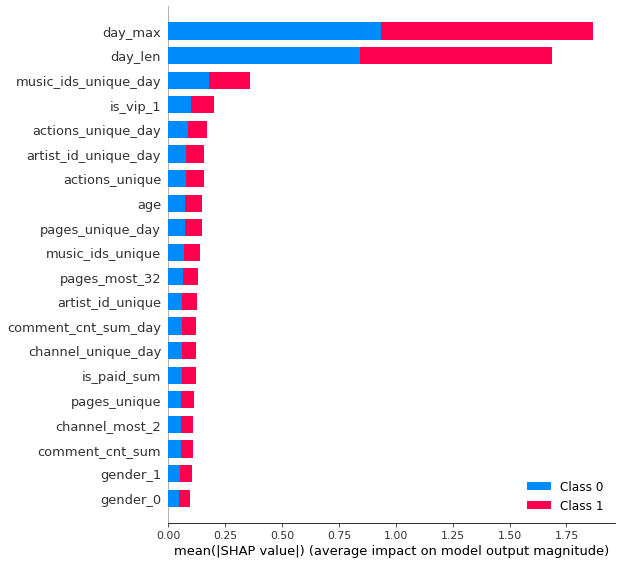

In [170]:
#基于SHAP值的解释
import shap
shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

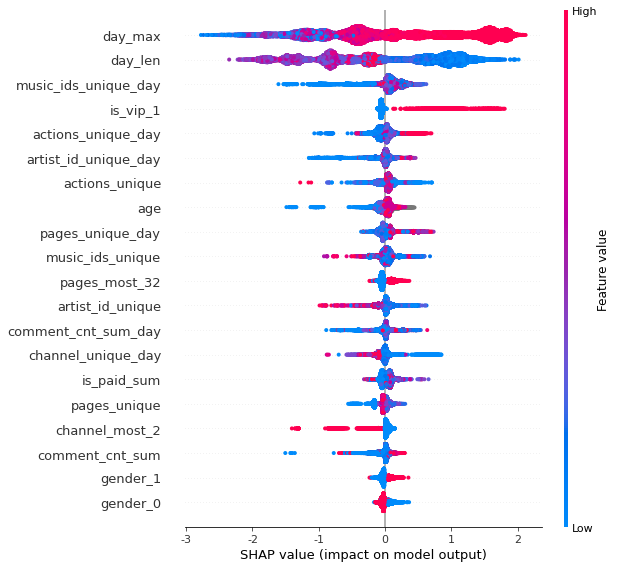

In [171]:
shap.summary_plot(shap_values[1], X_test)
#可以发现30天内最后1次使用日期越靠后越容易留存，vip更容易留存

### 小结
* 1.绝大多数用户(约98%)30天后仍持续使用，流失数据呈现高度不平衡性。
* 2.利用特征工程+lightGBM的方法，可以预测用户的流失情况，F1得分接近0.99。
* 3.通过SHAP分析发现，与流失(留存)关系最密切的5个变量：最后1次使用日期(day_max)，使用天数(day_len)，平均每(活跃)天收听的歌曲数(music_ids_unique_day)，是否vip客户(is_vip)，平均每(活跃)天操作次数(actions_unique_day)。

## 3.3.LSTM流失率建模

In [1]:
#读取pickle文件
import pickle
df=open('./user_data_df.pkl','rb')#注意此处是rb
user_data_df=pickle.load(df)
df.close()
print('读取完成')

读取完成


In [2]:
#序列参数提取
#pages_max=max(user_data_df['pages_seq'].map(max))
#actions_max=max(user_data_df['actions_seq'].map(max))
#print(pages_max)
#print(actions_max)

In [2]:
#样本集划分
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(user_data_df.loc[:,['days_list','pages_seq','actions_seq']],
                                                    user_data_df['is_churn'], 
                                                    test_size=0.2,
                                                    stratify=user_data_df['is_churn'],
                                                    random_state=100)
print('训练集和测试集样本量')
print(len(X_train))
print(len(X_test))
X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

训练集和测试集样本量
146073
36519


In [10]:
#lstm序列预处理
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from collections import defaultdict

#tqdm是一个Python模块，能以进度条的方式显式迭代的进度
from tqdm.auto import tqdm

class LstmDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]

def collate_fn(examples):
    lengths = torch.tensor([len(ex[0]) for ex in examples])
    inputs = [torch.tensor(ex[0]) for ex in examples]
    targets = torch.tensor([ex[1] for ex in examples], dtype=torch.long)
    # 对batch内的样本进行padding，使其具有相同长度
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, lengths, targets

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class):
        super(LSTM, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs, lengths):
        embeddings = self.embeddings(inputs)
        x_pack = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        hidden, (hn, cn) = self.lstm(x_pack)
        outputs = self.output(hn[-1])
        log_probs = F.log_softmax(outputs, dim=-1)
        return log_probs

embedding_dim = 128
hidden_dim = 256
num_class = 2
batch_size = 32
num_epoch = 5

In [11]:
#以日期序列作为输入
#套用NLP中词典的概念，词典是所有词标记的序数，能够覆盖所有句子中出现的词，例如从1到28，这里是30天，从0到30
print('活跃日期序列')
vocab_len=len(range(0,31))

#构建元组
train_data = [(x,y) for x, y in zip(X_train['days_list'], y_train)]
test_data = [(x,y) for x, y in zip(X_test['days_list'], y_test)]

train_dataset = LstmDataset(train_data)
test_dataset = LstmDataset(test_data)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)

#加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(vocab_len, embedding_dim, hidden_dim, num_class)
model.to(device) #将模型加载到GPU中（如果已经正确安装）

#训练过程

nll_loss = nn.NLLLoss(weight=torch.FloatTensor([10,1]))#由于数据不均衡，损失函数需要权重
optimizer = optim.Adam(model.parameters(), lr=0.001) #使用Adam优化器

model.train()
for epoch in range(num_epoch):
    total_loss = 0
    for batch in tqdm(train_data_loader, desc=f"Training Epoch {epoch}"):
        inputs, lengths, targets = [x.to(device) for x in batch]
        #print('inputs.shape:',inputs.shape)
        #print('lengths.shape:',lengths.shape)
        #print('targets.shape:',targets.shape)
        #由于原始数据存在字符串不规范，需要异常处理
        try:
            log_probs = model(inputs, lengths)
            loss = nll_loss(log_probs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except:
            pass
    print(f"Loss: {total_loss:.2f}")


活跃日期序列


Training Epoch 0:   0%|          | 0/4565 [00:00<?, ?it/s]

Loss: 1120.25


Training Epoch 1:   0%|          | 0/4565 [00:00<?, ?it/s]

Loss: 995.60


Training Epoch 2:   0%|          | 0/4565 [00:00<?, ?it/s]

Loss: 1001.38


Training Epoch 3:   0%|          | 0/4565 [00:00<?, ?it/s]

Loss: 984.42


Training Epoch 4:   0%|          | 0/4565 [00:00<?, ?it/s]

Loss: 968.40


In [15]:
#测试过程
prob_all = []
lable_all = []
acc=0
for batch in tqdm(test_data_loader, desc=f"Testing"):
    inputs, lengths, targets = [x.to(device) for x in batch]
    with torch.no_grad():
        try:
            output = model(inputs, lengths)
            prob_all.extend(output.argmax(dim=1).cpu().numpy())
            lable_all.extend(targets.numpy())
            acc += (output.argmax(dim=1) == targets).sum().item()
        except:
            pass
#输出在测试集上的准确率
print(f"Acc: {acc / len(test_data_loader):.2f}")

Testing:   0%|          | 0/36519 [00:00<?, ?it/s]

Acc: 0.97


In [17]:
#测试集结果
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix
print('准确率')
print(accuracy_score(lable_all,prob_all))
print('f1score')
print(f1_score(lable_all,prob_all)) 
print('auc')
print(roc_auc_score(lable_all,prob_all))
print('混淆矩阵')
confusion_matrix(lable_all,prob_all)

准确率
0.9688920532340216
f1score
0.9841212155097704
auc
0.6495953625578644
混淆矩阵


array([[  179,   380],
       [  756, 35203]])

### 小结
* 1.仅使用用户活跃天数序列(例如[2,4,15]代表第2,4,15天有操作)，LSTM也能较准确预测用户的流失情况，F1得分为0.98，略低于lightGBM模型。
* 2.LSTM对硬件资源消耗大，运行很慢，预期想尝试用户操作类型序列和页面序列，单个Epoch都需要40多个小时，就没有处理。
* 3.LSTM的参数很多，由于资源有限暂时忽略，后续可以尝试。